In [1]:
# Import dependencies
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import time as tm
import os.path
import random as rnd
import copy
import string

from openpyxl import load_workbook
from openpyxl.utils.cell import range_boundaries
from grid_generator_latest import generate_grid
from collections import Counter

In [2]:
# Create the Solver object for either NEOS or a local solver
def SetUpSolver(Model):
    Model.Options = None
    if Neos:
        Solver = pyo.SolverManagerFactory('neos')   # Solver on NEOS
        if pyo.value(Model.Engine) == 'cplex':   # Linear
            Model.Options = {'timelimit': Model.TimeLimit, 'mipgap': MipGap}
        elif pyo.value(Model.Engine) == 'octeract':   # Linear or non-linear
            Model.Options = {'MAX_SOLVER_TIME': Model.TimeLimit, 'MILP_SOLVER': 'HIGHS'}
        elif pyo.value(Model.Engine) == 'couenne':   # Non-linear
            print('No options for Couenne')
        else:
            print('Unknown NEOS solver when setting options')
    else:
        Solver = pyo.SolverFactory(pyo.value(Model.Engine))   # Local solver installed
        if pyo.value(Model.Engine) == 'couenne':   # Non-linear
            print('No options for Couenne') # Couenne doesn't accept command line options, use couenne.opt instead
        elif pyo.value(Model.Engine) == 'cbc':   # Linear
            Solver.options['seconds'] = pyo.value(Model.TimeLimit)
            Solver.options['log'] = 1   # Default is 1. 2 or 3 provides more detail. Also have slog, which provides much more detail
        elif pyo.value(Model.Engine) == 'appsi_highs':   # Linear
            Solver.options['time_limit'] = pyo.value(Model.TimeLimit)
            Solver.options['log_file'] = 'highs.log'   # Sometimes HiGHS doesn't update the console as it solves, so write log file too
            Solver.options['mip_rel_gap'] = MipGap   # Relative gap. 10 = stop at first feasible solution. 0 = find optimum. 0.1 = within 10% of optimum
            #Solver.options['parallel'] = 'on'
            #Solver.options['mip_heuristic_effort'] = 0.2   # default = 0.05, range = 0..1
        elif pyo.value(Model.Engine) == 'gurobi_direct':
            Solver.options['timelimit'] = pyo.value(Model.TimeLimit)
            Solver.options['logfile'] = 'gurobi.log'
            Solver.options['mipgap'] = MipGap
            Solver.options['solutionlimit'] = SolutionLimit
            #Solver.options['heuristics'] = 0.25   # 0..1 default = 0.05
        else:
            print('Unknown local solver when setting options')
    
    return Solver, Model

# Call either NEOS or a local solver
def CallSolver(Solver, Model):
    if Neos:
        if Model.Options == None:
            Results = Solver.solve(Model, load_solutions = LoadSolution, tee = Verbose, solver = Model.Engine)
        else:
            Results = Solver.solve(Model, load_solutions = LoadSolution, tee = Verbose, solver = Model.Engine, options = Model.Options)
    else:
        Results = Solver.solve(Model, load_solutions = LoadSolution, tee = Verbose)
    
    return Results, Model

# Define model
# This formulation is more deliberate about creating constraint terms and fixing variables at 0, in an attempt to make the model smaller and faster
# It also has switches to include/exclude constraints and alternative objective functions

def DefineModel(Model):
    print('Defining model...')
    Model.Allocation = pyo.Var(Model.Candidate, Model.GridWords, within = pyo.Binary, initialize = 0)   # Allocate candidate words to the grid

    def rule_PosOnce(Model, g):   # Allocate exactly one candidate to each grid word position
        ColumnTotal = 0
        TermsAdded = 0
        for c in Model.Candidate:
            if pyo.value(Model.Length[c]) == pyo.value(Model.GridLengths[g]):   # Candidate word length must match grid word length
                ColumnTotal += Model.Allocation[c, g]
                TermsAdded += 1
        if TermsAdded == 0:
            return pyo.Constraint.Skip
        else:
            return ColumnTotal == 1
    Model.EachPositionOnce = pyo.Constraint(Model.GridWords, rule = rule_PosOnce)

    if SingleWordSquare:
        def rule_Symmetry(Model, g):   # Ensure that across words = down words, for creating single word squares
            NumWords = len(Model.GridWords)   # Always an even number in a square grid
            if g <= NumWords / 2 - 1:
                return sum(Model.Allocation[c, g] for c in Model.Candidate) == sum(Model.Allocation[c, g + NumWords / 2] for c in Model.Candidate)
            else:
                return pyo.Constraint.Skip
        Model.Symmetry = pyo.Constraint(Model.GridWords, rule = rule_Symmetry)
    
    def rule_WordOnce(Model, c):
        RowTotal = 0
        TermsAdded = 0
        if SingleWordSquare:
            rhs = 2   # Each allocated word is used twice (across and down)
        else:
            rhs = 1   # Each allocated word must be unique
        for g in Model.GridWords:
            if pyo.value(Model.Length[c]) == pyo.value(Model.GridLengths[g]):   # Candidate word length must match grid word length
                RowTotal += Model.Allocation[c, g]
                TermsAdded += 1
        if TermsAdded == 0:
            return pyo.Constraint.Skip
        else:
            return RowTotal <= rhs
    Model.EachWordOnce = pyo.Constraint(Model.Candidate, rule = rule_WordOnce)

    # Fix some variables. Replaces the rule_Fit constraint. This constraint substantially reduces solve time
    for g in Model.GridWords:   # Reduce variables by fixing allocation variables to zero if candidate word length doesn't match grid word length
        for c in Model.Candidate:    
            if pyo.value(Model.Length[c]) != pyo.value(Model.GridLengths[g]):
                Model.Allocation[c, g].fix(0)

    def rule_Intersection(Model, g1, g2, w, h):   # The intersection of grid words must have the same letter
                                                  # The if statements within the sums remove terms that are fixed at zero, so no change in reported model size
        if pyo.value(Model.AcrossRef[h, w]) != 0 \
                and pyo.value(Model.DownRef[h, w]) != 0 \
                and g1 == pyo.value(Model.AcrossRef[h, w]) - 1 \
                and g2 == pyo.value(Model.DownRef[h, w]) - 1:
            return sum(Model.Allocation[c, g1] * Model.Word[c, pyo.value(Model.AcrossPos[h, w]) - 1] for c in Model.Candidate \
                    if pyo.value(Model.Length[c]) == pyo.value(Model.GridLengths[g1])) == \
                    sum(Model.Allocation[c, g2] * Model.Word[c, pyo.value(Model.DownPos[h, w]) - 1] for c in Model.Candidate \
                    if pyo.value(Model.Length[c]) == pyo.value(Model.GridLengths[g2]))
        else:
            return pyo.Constraint.Skip
    Model.Crossover = pyo.Constraint(Model.GridWords, Model.GridWords, Model.GridWidth, Model.GridHeight, rule = rule_Intersection)

    CandidateUsed = []   # Use and fix randomly selected words at most once each
    if len(Model.FixGridWord) == 0:
        print('No initial words')
    else:   # Randomly select words to fill specified grid word positions
        print('Initial words:')
        for f in range(0, len(Model.FixGridWord)):
            CandidateList = []
            for c in Model.Candidate:
                if pyo.value(Model.Length[c]) == pyo.value(Model.GridLengths[pyo.value(Model.FixGridWord[f]) - 1]) and c not in CandidateUsed:
                    CandidateList.append(c)
            CandidateUsed = rnd.sample(CandidateList, 1)
            Model.Allocation[CandidateUsed, pyo.value(Model.FixGridWord[f]) - 1].fix(1)   # Fix variable for allocation of selected word
            CurrWord = ""
            for i in range(0, MaxWordLength):
                CurrWord += chr(pyo.value(Model.Word[CandidateUsed, i]))
            print(pyo.value(Model.FixGridWord[f]), ": ", CurrWord)   # Output selected word
    print()

    if ObjectiveChoice == 3:
        Model.Cross = pyo.Set(initialize = range(0, pyo.value(Model.NumIntersections)))
        Model.Same = pyo.Var(Model.Cross, within = pyo.Binary, initialize = 0)
        Model.Inter = pyo.ConstraintList()
        CurrZ = 0
        for h in Model.GridHeight:
            for w in Model.GridWidth:
                for g1 in Model.GridWords:
                    for g2 in Model.GridWords:
                        if pyo.value(Model.AcrossRef[h, w]) != 0 \
                                and pyo.value(Model.DownRef[h, w]) != 0 \
                                and g1 == pyo.value(Model.AcrossRef[h, w]) - 1 \
                                and g2 == pyo.value(Model.DownRef[h, w]) - 1:
                            Model.Inter.add(sum(Model.Allocation[c, g1] * Model.Word[c, pyo.value(Model.AcrossPos[h, w]) - 1] \
                                    for c in Model.Candidate if pyo.value(Model.Length[c]) == pyo.value(Model.GridLengths[g1])) \
                                    - sum(Model.Allocation[c, g2] * Model.Word[c, pyo.value(Model.DownPos[h, w]) - 1] for c in Model.Candidate \
                                    if pyo.value(Model.Length[c]) == pyo.value(Model.GridLengths[g2])) >= 1 - 26 * Model.Same[CurrZ])
                            CurrZ += 1

    def rule_Obj(Model):   # Min or Max total allocated word frequency. The if statement removes terms that are fixed at zero, so no change in reported model size
                           # Weighting by Model.Rank[c] rather than Model.Frequency[c] is sometimes faster. Though, to be consistent, also need to change the objective's direction
        if ObjectiveChoice == 3:
            return sum(Model.Same[z] for z in Model.Cross)
        elif ObjectiveChoice == 2:
            return sum(Model.Allocation[c, g] for g in Model.GridWords for c in Model.Candidate if pyo.value(Model.Length[c]) == pyo.value(Model.GridLengths[g]))
        else:   # option 1
            return sum(sum(Model.Allocation[c, g] for g in Model.GridWords) * Model.Frequency[c] for c in Model.Candidate \
                    if pyo.value(Model.Length[c]) == pyo.value(Model.GridLengths[g]))            
    if Direction == 1:
        Model.Obj = pyo.Objective(rule = rule_Obj, sense = pyo.maximize)
    else:
        Model.Obj = pyo.Objective(rule = rule_Obj, sense = pyo.minimize)

In [3]:
# Load data from Excel file
def GetData(WordFile, WordWorksheet, GridFile, GridWorksheet):
    Rank = LoadFromExcel(WordFile, WordWorksheet, 'rank')
    Frequency = LoadFromExcel(WordFile, WordWorksheet, 'frequency')
    Word = LoadFromExcel(WordFile, WordWorksheet, 'word')
    Rank.columns = ['Candidate']
    Frequency.columns = ['Candidate']
    Word.columns = ['Candidate']
    
    GridWords = LoadFromExcel(GridFile, GridWorksheet, 'NumWords')
    NumIntersections = LoadFromExcel(GridFile, GridWorksheet, 'Intersections')
    AcrossRef = LoadFromExcel(GridFile, GridWorksheet, 'AcrossRef')
    AcrossPos = LoadFromExcel(GridFile, GridWorksheet, 'AcrossPos')
    DownRef = LoadFromExcel(GridFile, GridWorksheet, 'DownRef')
    DownPos = LoadFromExcel(GridFile, GridWorksheet, 'DownPos')
    UseFixWords = LoadFromExcel(GridFile, GridWorksheet, 'UseFixWords')
    FixWords = LoadFromExcel(GridFile, GridWorksheet, 'FixWords')
    
    return Rank, Frequency, Word, GridWords, NumIntersections, AcrossRef, AcrossPos, DownRef, DownPos, UseFixWords, FixWords

# Define model data, assigning all data to the Model
def DefineModelData(Model, Rank, Frequency, Word, GridWords, NumIntersections, AcrossRef, AcrossPos, DownRef, DownPos, UseFixWords, FixWords):

    Grid_rows, Grid_cols = np.shape(AcrossRef)   # Note: Model defined as h, w while data accessed via w, h

    Model.GridWords = pyo.Set(initialize = range(0, GridWords.iloc[0][0]))   # Set for number of words in the grid
    Model.NumIntersections = NumIntersections.iloc[0][0]
    Model.GridWidth = pyo.Set(initialize = range(0, Grid_cols))   # Set width of the grid
    Model.GridHeight = pyo.Set(initialize = range(0, Grid_rows))   # Set for the height of the grid
    Model.AcrossRef = pyo.Param(Model.GridHeight, Model.GridWidth, within = pyo.NonNegativeIntegers, mutable = True)
    Model.AcrossPos = pyo.Param(Model.GridHeight, Model.GridWidth, within = pyo.NonNegativeIntegers, mutable = True)
    Model.DownRef = pyo.Param(Model.GridHeight, Model.GridWidth, within = pyo.NonNegativeIntegers, mutable = True)
    Model.DownPos = pyo.Param(Model.GridHeight, Model.GridWidth, within = pyo.NonNegativeIntegers, mutable = True)
    Model.GridLengths = pyo.Param(Model.GridWords, within = pyo.NonNegativeIntegers, mutable = True, initialize = 0)

    for w in Model.GridWidth:
        for h in Model.GridHeight:
            Model.AcrossRef[h, w] = AcrossRef[w][h]   # Populate grid encoding
            Model.AcrossPos[h, w] = AcrossPos[w][h]
            Model.DownRef[h, w] = DownRef[w][h]
            Model.DownPos[h, w] = DownPos[w][h]
            if AcrossRef[w][h] >= 1:   # Get length of "across" words by looking at maximum position of each word
                Model.GridLengths[AcrossRef[w][h] - 1] = max(pyo.value(Model.GridLengths[AcrossRef[w][h] - 1]), AcrossPos[w][h])
            if DownRef[w][h] >= 1:   # Get length of "down" words by looking at maximum position of each word
                Model.GridLengths[DownRef[w][h] - 1] = max(pyo.value(Model.GridLengths[DownRef[w][h] - 1]), DownPos[w][h])

    SelectedWords = []   # Select words as candidates only if they match the grid's word lengths
    GridWordLengths = []   # Length of words in the grid
    for g in Model.GridLengths:
        if pyo.value(Model.GridLengths[g]) not in GridWordLengths:
            GridWordLengths.append(pyo.value(Model.GridLengths[g]))
    GridWordLengths.sort()   # e.g. [4,5,9,15]
    for c in range(0, len(Word)):
        if len(Word['Candidate'][c]) in GridWordLengths:
            SelectedWords.append(c)   # Subset of lexicon words, included only if they fit in the grid

    Size = SampleSize
    if Size == 0:
        Size = len(SelectedWords)
    else:
        Size = min(SampleSize, len(SelectedWords))
    print(f'Lexicon size: {Size:,.0f} (out of {len(SelectedWords):,.0f} that fit, from lexicon of {len(Word):,.0f})')   # After excluding words that don't fit in the grid
    
    Model.Candidate = pyo.Set(initialize = range(0, Size))   # Set of candidate words 
    Model.Ascii = pyo.Set(initialize = range(0, MaxWordLength))   # Set of ASCII character codes in a word
    Model.Rank = pyo.Param(Model.Candidate, within = pyo.NonNegativeIntegers, mutable = True)   # Lexicon rank
    Model.Frequency = pyo.Param(Model.Candidate, within = pyo.NonNegativeReals, mutable = True)   # Lexicon frequency
    Model.Length = pyo.Param(Model.Candidate, within = pyo.NonNegativeIntegers, mutable = True)   # Number of characters in each candidate word
    Model.Word = pyo.Param(Model.Candidate, Model.Ascii, within = pyo.NonNegativeIntegers, mutable = True)   # Each candidate word, split into ASCII codes
    
    List = [i for i in range(0, len(SelectedWords))]   # Row numbers for whole lexicon
    if Size == len(SelectedWords):
        Sample = List   # Use whole lexicon
    else:
        Sample = rnd.sample(List, Size)   # Use sample of lexicon
    CandidateNum = 0
    for c in range(0, len(SelectedWords)):   # Populate data for selected sample words
        if c in Sample:
            Model.Rank[CandidateNum] = Rank['Candidate'][SelectedWords[c]]
            Model.Frequency[CandidateNum] = Frequency['Candidate'][SelectedWords[c]]
            Model.Length[CandidateNum] = len(Word['Candidate'][SelectedWords[c]])
            LettersAscii = list(bytes(Word['Candidate'][SelectedWords[c]], 'ascii'))   # ASCII codes for word's characters
            for a in Model.Ascii:   # list of ASCII codes for each letter of a word, padded with zeroes beyond the word's length
                if a >= len(LettersAscii):
                    Model.Word[CandidateNum, a] = 0
                else:
                    Model.Word[CandidateNum, a] = LettersAscii[a]
            CandidateNum += 1
                
    if UseFixWords[0][0] == False:   # Data indicating whether to use the list of word positions to fix
        NumFixWords = 0   # Do not fix words
    else:
        NumFixWords = len(FixWords)   # Or number of words to fix
    Model.FixGridWord = pyo.Param(range(0, NumFixWords), within = pyo.NonNegativeIntegers, mutable = True, initialize = 0)
    for f in range(0, NumFixWords):   # Populate list of word positions to fix, if any
        Model.FixGridWord[f] = FixWords[0][f]
        
def WriteOutput(Model, Results):
    Obj = pyo.value(Model.Obj())
    print(f'Objective: {Obj:,.2f}')
    print('Intersections: ', len(Model.Crossover))   # Number of across/down word intersections
    print('\nWords:')
    for g in Model.GridWords:
        for c in Model.Candidate:
            if np.isclose(pyo.value(Model.Allocation[c, g]), 1):   # Allow for small deviations from binary values
                CurrWord = ""
                for i in range(0, pyo.value(Model.Length[c])):
                    CurrWord += chr(pyo.value(Model.Word[c, i]))   # Get characters of allocated words
                print(g + 1, ": ", CurrWord)

In [4]:
# Record time checkpoints
# Requires global variable: Checkpoints = []
def Timer(Point):   # String label for current checkpoint
    Checkpoints.append([Point, tm.perf_counter()])
# Output list of checkpoint labels and times
def WriteCheckpoints():
    print('\nCheckpoint    Seconds')
    print('---------------------')
    Start = Checkpoints[0][1]
    for i in range(1, len(Checkpoints)):
        Point = Checkpoints[i][0]
        TimeStep = Checkpoints[i][1] - Start
        print(f'{Point:12}{TimeStep:9,.1f}')
# Generic loader from Excel file, given worksheet and named range
def LoadFromExcel(ExcelFile, Worksheet, Range):
    wb = load_workbook(filename=ExcelFile, read_only = True, data_only = True)
    ws = wb[Worksheet]
    dests = wb.defined_names[Range].destinations
    for title, coord in dests:
        min_col, min_row, max_col, max_row = range_boundaries(coord)
        data = ws.iter_rows(min_row, max_row, min_col, max_col, values_only = True)
    df = pd.DataFrame(data)
    return df
# Write model to file, if required. The format will be inferred by Pyomo from the file extension, e.g. .gams or .nl
def WriteModelToFile(WriteFile, Model):
    if WriteFile:
        Model.write(ModelFile, io_options={'symbolic_solver_labels': False})   # symbolic_solver_labels of True is easier to read, but a longer file

In [5]:
def Main():
    Timer('Start');
    Finished = False
    Iteration = 0
    Seed = RandomSeed

    while not Finished:
        rnd.seed(Seed)
        Model = pyo.ConcreteModel(name = ModelName)
        Model.Engine = SolverName
        Model.TimeLimit = TimeLimit
        if Iteration == 0:
            print(Model.name)   # Print the model name only once
            print('Grid:    ', GridFile.rsplit('\\', 1)[-1])
            print('Lexicon: ', WordFile.rsplit('\\', 1)[-1])
        print('\nIteration: ', Iteration + 1, ' of ', MaxIterations)
        Rank, Frequency, Word, GridWords, NumIntersections, AcrossRef, AcrossPos, DownRef, DownPos, UseFixWords, FixWords = GetData(WordFile, WordWorksheet, GridFile, GridWorksheet)
        DefineModelData(Model, Rank, Frequency, Word, GridWords, NumIntersections, AcrossRef, AcrossPos, DownRef, DownPos, UseFixWords, FixWords)
        Solver, Model = SetUpSolver(Model)
        Timer('Setup');
        DefineModel(Model)
        WriteModelToFile(WriteFile, Model)   # Write model to file, if required
        Timer('Create model');
        print('Calling solver...')
        Results, Model = CallSolver(Solver, Model)
        Timer('Solved');
        
        if SolverName == 'gurobi_direct':
            SolutionFound = (Results.solver.status == pyo.SolverStatus.ok) or (Solver._solver_model.SolCount >= 1)   # Feasible/optimal or found at least one feasible solution
        else:
            SolutionFound = (Results.solver.status == pyo.SolverStatus.ok)
            
        if SolutionFound:
            print('Solution for random seed:', Seed, '\n')
            Model.solutions.load_from(Results)   # Defer loading results until now, in case there is no solution to load
            WriteOutput(Model, Results)
            if StopOnFirst:   # Ignore iteration count and stop on first solution
                Finished = True
        else:
            print('No solution for random seed:', Seed, '(', Results.solver.termination_condition, ')', '\n')
        Iteration += 1        
        Seed += 1
        if Iteration >= MaxIterations:   # If not stopping on first iteration, then stop after specified number of iterations
            Finished = True
    Timer('Finish')
    WriteCheckpoints()

In [6]:
def clean(text):
    return " ".join(text.strip().split())

class Crossword:
    def __init__(self, data):
        self.initialize_grids(grid=data["grid"])
        self.initialize_clues(clues=data["clues"])
        self.size = (7, 7)
        self.initialize_variables()

    def initialize_grids(self, grid):
        self.letter_grid = [[grid[j][i][1] if type(grid[j][i]) == list else "" for i in
                             range(len(grid[0]))] for j in range(len(grid))]
        self.number_grid = [[grid[j][i][0] if type(grid[j][i]) == list else "" for i in
                             range(len(grid[0]))] for j in range(len(grid))]
        self.grid_cells = {}

    def initialize_clues(self, clues):
        self.across = clues["across"]
        self.down = clues["down"]

    def initialize_variable(self, position, clues, across=True):
        row, col = position
        cell_number = self.number_grid[row][col]
        assert cell_number in clues, print("Missing clue")
        word_id = cell_number + "A" if across else cell_number + "D"
        clue = clean(clues[cell_number][0])
        answer = clean(clues[cell_number][1])
        for idx in range(len(answer)):
            cell = (row, col + idx) if across else (row + idx, col)
            if cell in self.grid_cells:
                self.grid_cells[cell].append(word_id)
            else:
                self.grid_cells[cell] = [word_id]
            if word_id in self.variables:
                self.variables[word_id]["cells"].append(cell)
            else:
                self.variables[word_id] = {"clue": clue, "gold": answer, "cells": [cell], "crossing": []}

    def initialize_crossing(self):
        for word_id in self.variables:
            cells = self.variables[word_id]["cells"]
            crossing_ids = []
            for cell in cells:
                crossing_ids += list(filter(lambda x: x!= word_id, self.grid_cells[cell]))
            self.variables[word_id]["crossing"] = crossing_ids

    def initialize_variables(self):
        self.variables = {}
        for row in range(len(self.number_grid)):
            for col in range(len(self.number_grid[0])):
                cell_number = self.number_grid[row][col]
                if self.number_grid[row][col] != "":
                    if cell_number in self.across:
                        self.initialize_variable((row, col), self.across, across=True)
                    if cell_number in self.down:
                        self.initialize_variable((row, col), self.down, across=False)
        self.initialize_crossing()

def get_me_a_random_clue(answer_length):
    random_index = random.randint(0, len(all_clues))
    while 'across' in all_clues[random_index] or 'down' in all_clues[random_index]:
        random_index = random.randint(0, len(all_clues))
    return all_clues[random_index]

def find_grid_position(grid_nums, clue_num, n_rows):
    reshaped_grid = [grid_nums[i:i + n_rows] for i in range(0, len(grid_nums), n_rows)]

    for i in range(len(reshaped_grid)):
        for j in range(len(reshaped_grid[0])):
            if reshaped_grid[i][j] == clue_num:
                return (i, j)

def find_answer_length(main_grid, position, grid_size, across = True):
    rows, cols = grid_size
    i, j = position
    count = 0
    if across:
        for idx in range(j, cols):
            if main_grid[i][idx] == '.':
                return count
            else:
                count += 1
    else:
        for idx in range(i, rows):
            if main_grid[idx][j] == '.':
                return count
            else:
                count += 1
    return count

def json_CA_json_converter(json_file_path, is_path):
    if is_path:
        with open(json_file_path, "r") as file:
            data = json.load(file)
    else:
        data = json_file_path

    json_conversion_dict = {}

    rows = data["size"]["rows"]
    cols = data["size"]["cols"]

    grid_list = data['grid']

    main_grid = [grid_list[i:i + rows] for i in range(0, len(grid_list), rows)]


    json_conversion_dict["metadata"] = {"rows": rows, "cols": cols}

    across_grid_nums = data['across_nums']
    down_grid_nums = data['down_nums']

    across_clue_answer = {}
    down_clue_answer = {}

    grid_info = data["grid"]
    grid_num = data["gridnums"]
    reshaped_grid = [grid_num[i:i + rows] for i in range(0, len(grid_num), rows)]

    for clue_num in across_grid_nums:
        position = find_grid_position(grid_num, clue_num, rows)
        answer_count = find_answer_length(main_grid, position, (rows, cols))
        random_clue = "something something"
        across_clue_answer[str(clue_num)] = [random_clue, "".join(['A' for _ in range(answer_count)])]

    for clue_num in down_grid_nums:
        position = find_grid_position(grid_num, clue_num, rows)
        answer_count = find_answer_length(main_grid, position, (rows, cols), False)
        random_clue = "something something"
        down_clue_answer[str(clue_num)] = [random_clue, "".join(['A' for _ in range(answer_count)])]

    json_conversion_dict["clues"] = {
          "across": across_clue_answer,
          "down": down_clue_answer,
      }

    grid_info_list = []
    for i in range(rows):
        row_list = []
        for j in range(cols):
            if grid_info[i * rows + j] == ".":
                row_list.append("BLACK")
            else:
                if grid_num[i * rows + j] == 0:
                    row_list.append(["", grid_info[i * rows + j]])
                else:
                    row_list.append(
                        [str(grid_num[i * rows + j]), grid_info[i * rows + j]]
                    )
        grid_info_list.append(row_list)

    json_conversion_dict["grid"] = grid_info_list

    return json_conversion_dict        
        

def find_indices(lst, element):
    indices = []
    start_index = None

    for i, value in enumerate(lst):
        if value == element:
            if start_index is None:
                start_index = i
        elif start_index is not None:
            indices.append((start_index, i - 1))
            start_index = None

    if start_index is not None:
        indices.append((start_index, len(lst) - 1))

    return indices

def get_grid_data_MILP(size = 7, b_factor = 6, display_grid = False):
    json_data = generate_grid(grid_size = size, b_factor = b_factor, display_grid = display_grid)
    rows, cols = json_data['size']['rows'], json_data['size']['cols']
    grid_2d = ['|'.join(json_data['grid'][i:i+cols]).replace('.', '0').split('|') for i in range(0, len(json_data['grid']), rows)]
    grid_2d = [[0 if col == '0' else -1 for col in row] for row in grid_2d]
    
    puzzle = json_CA_json_converter(json_data, False)
    crossword = Crossword(puzzle)
    all_cells = []
    for var, data in crossword.variables.items():
        all_cells.extend(data['cells'])
        
    intersection_count_matrix = [[0] * cols for _ in range(rows)]

    for cell in all_cells:
        intersection_count_matrix[cell[0]][cell[1]] += 1

    intersection_count = 0
    for row in intersection_count_matrix:
        for cell_element in row:
            if cell_element > 1:
                intersection_count += 1
    
    across_ref_ = copy.deepcopy(grid_2d)
    across_pos_ = copy.deepcopy(grid_2d)
    down_ref_ = copy.deepcopy(grid_2d)
    down_pos_ = copy.deepcopy(grid_2d)

    ref_count = 1
    pos_count = 1
    for i, row in enumerate(grid_2d):
        indices = find_indices(row, -1)
        for index_tuple in indices:
            pos_count = 1
            for j in range(index_tuple[0], index_tuple[1] + 1):
                across_ref_[i][j] = ref_count
                across_pos_[i][j] = pos_count
                pos_count += 1
            ref_count += 1

    for i in range(len(grid_2d)):
        for j in range(len(grid_2d[0])):
            if down_ref_[i][j] == -1:
                pos_count = 1
                for k in range(i, len(grid_2d)):
                    if down_ref_[k][j] != 0:
                        down_ref_[k][j] = ref_count
                        down_pos_[k][j] = pos_count
                        pos_count += 1
                    elif down_ref_[k][j] == 0:
                        break
                ref_count += 1

    return pd.DataFrame(across_ref_), pd.DataFrame(across_pos_), pd.DataFrame(down_ref_), pd.DataFrame(down_pos_), pd.DataFrame([ref_count-1]), pd.DataFrame([intersection_count]), pd.DataFrame([False]), pd.DataFrame([8, 19])

def get_word_file_MILP(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        words = file.read().split()

    translator = str.maketrans('', '', string.punctuation)
    cleaned_words = [word.translate(translator).lower() for word in words]

    char_frequencies = Counter(''.join(cleaned_words))

    def word_score(word):
        return sum(char_frequencies[char] for char in word) / len(word)

    word_scores = {word: word_score(word) for word in cleaned_words}

    frequency_list = []
    word_list = []
    for word, score in sorted(word_scores.items(), key=lambda x: x[1], reverse=True):
        word_list.append(word)
        frequency_list.append(score)

    Rank = pd.DataFrame(range(1, len(word_list) + 1), columns = ['Candidate'])
    Word = pd.DataFrame(word_list, columns = ['Candidate'])
    Frequency = pd.DataFrame(frequency_list, columns = ['Candidate'])
    return Rank, Word, Frequency

In [7]:
# Globals

# Data assumptions
Lexicon = 'gutenberg.xlsx'   # gutenberg.xlsx
Grid = 'grid-7-2.xlsx'
SampleSize = 0   # Number of words to randomly select from WordFile. 0 means select all words
SingleWordSquare = False   # Use True only for 100% dense square grids, otherwise must be False

# Run options
MipGap = 100   # Highs: 100 (10000%) = stop on first feasible solution, or thereabouts; 0 = find optimum; CPLEX: 1 = first feasible, 0 = optimal; Gurobi: 100
SolutionLimit = 1   # Gurobi only, 1 = stop on first MIP solution
MaxIterations = 3   # Iterate random seeds, starting with RandomSeed and incrementing by 1 each iteration
StopOnFirst = True   # Stop on first solution, even if < MaxIterations
RandomSeed = 1   # Starting value
Direction = 1   # 1 = maximize, -1 = minimize
ObjectiveChoice = 3   # 1 = Allocated words weighted by frequency; 2 = Allocated words; 3 = Number of intersections with same letter (requires maximize)

# Solver options
Neos = False
SolverName = 'gurobi_direct'   #'appsi_highs'   'gurobi_direct'
os.environ['NEOS_EMAIL'] = 'your.email@example.com'
Verbose = True
LoadSolution = False
TimeLimit = 4*3600   # seconds

# Model file
WriteFile = False
ModelFile = 'model-2.gams'   # Extensions: .gams .lp .nl

# Fixed
ModelName = 'Crossword creator - Model 2'
Checkpoints = []   # List of time checkpoints
WordWorksheet = 'Data'
GridWorksheet = 'Grid'
WordFile = os.path.join(os.getcwd() + '\lexicon', Lexicon)
GridFile = os.path.join(os.getcwd() + '\grid', Grid)
MaxWordLength = 11

Crossword creator - Model 2
Grid:     grid-7-2.xlsx
Lexicon:  gutenberg.xlsx

Iteration:  1  of  3


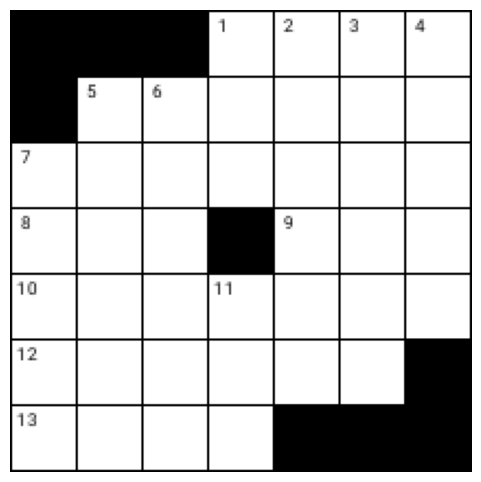

Lexicon size: 18,902 (out of 18,902 that fit, from lexicon of 35,259)
Defining model...
No initial words

Calling solver...
Set parameter TimeLimit to value 14400
Set parameter LogFile to value "gurobi.log"
Set parameter MIPGap to value 100
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22000.2))

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 18998 rows, 302472 columns and 820424 nonzeros
Model fingerprint: 0xf7e3c39b
Variable types: 0 continuous, 302472 integer (302472 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 40 rows and 240536 columns (presolve time = 5s) ...
Presolve removed 40 rows and 240536 columns (presolve time = 10s) ...
Presolve removed

In [ ]:
Timer('Start');
Finished = False
Iteration = 0
Seed = RandomSeed

while not Finished:
    rnd.seed(Seed)
    Model = pyo.ConcreteModel(name = ModelName)
    Model.Engine = SolverName
    Model.TimeLimit = TimeLimit
    if Iteration == 0:
        print(Model.name)   # Print the model name only once
        print('Grid:    ', GridFile.rsplit('\\', 1)[-1])
        print('Lexicon: ', WordFile.rsplit('\\', 1)[-1])
    print('\nIteration: ', Iteration + 1, ' of ', MaxIterations)
    
#     Rank, Frequency, Word, GridWords, NumIntersections, AcrossRef, AcrossPos, DownRef, DownPos, UseFixWords, FixWords = GetData(WordFile, WordWorksheet, GridFile, GridWorksheet)
    
    AcrossRef, AcrossPos, DownRef, DownPos, GridWords, NumIntersections, UseFixWords, FixWords = get_grid_data_MILP(size = 7, b_factor = 5, display_grid = True)
    Rank, Word, Frequency = get_word_file_MILP("./gutenberg_lexicon.txt")
    
    DefineModelData(Model, Rank, Frequency, Word, GridWords, NumIntersections, AcrossRef, AcrossPos, DownRef, DownPos, UseFixWords, FixWords)
    Solver, Model = SetUpSolver(Model)
    Timer('Setup');
    DefineModel(Model)
    WriteModelToFile(WriteFile, Model)   # Write model to file, if required
    Timer('Create model');
    print('Calling solver...')
    Results, Model = CallSolver(Solver, Model)
    Timer('Solved');

    if SolverName == 'gurobi_direct':
        SolutionFound = (Results.solver.status == pyo.SolverStatus.ok) or (Solver._solver_model.SolCount >= 1)   # Feasible/optimal or found at least one feasible solution
    else:
        SolutionFound = (Results.solver.status == pyo.SolverStatus.ok)

    if SolutionFound:
        print('Solution for random seed:', Seed, '\n')
        Model.solutions.load_from(Results)   # Defer loading results until now, in case there is no solution to load
        WriteOutput(Model, Results)
        if StopOnFirst:   # Ignore iteration count and stop on first solution
            Finished = True
    else:
        print('No solution for random seed:', Seed, '(', Results.solver.termination_condition, ')', '\n')
    Iteration += 1        
    Seed += 1
    if Iteration >= MaxIterations:   # If not stopping on first iteration, then stop after specified number of iterations
        Finished = True
Timer('Finish')
WriteCheckpoints()

In [ ]:
grid_data = generate_grid(grid_size = 7, b_factor = 6, display_grid = True)
puzzle = json_CA_json_converter(grid_data, False)

crossword = Crossword(puzzle)

In [ ]:
no_rows, no_cols = puzzle['metadata']['rows'], puzzle['metadata']['cols']
intersection_count_matrix = [[0] * no_cols for _ in range(no_rows)]

for cell in all_cells:
    intersection_count_matrix[cell[0]][cell[1]] += 1

intersection_count = 0
for row in intersection_count_matrix:
    for cell_element in row:
        if cell_element > 1:
            intersection_count += 1
intersection_count